In [89]:
import cPickle as pickle
import json
import matplotlib.pyplot as plt
import numpy as np
import random

from nltk import word_tokenize

In [41]:
# Read glove vocab.
glove_vocab = set([ x.strip() for x in \
                      open("../../data/glove/glove.840B.vocab.txt").readlines() ])

In [81]:
# Check GloVe vocab.
"Santa" in glove_vocab

True

In [59]:
dev_data = pickle.load(open("../../data/match_lstm/dev_upper_punct_fullvocab.p", "rb"))
questions = dev_data.questions
paragraphs = dev_data.paragraphs
tokenized_paras = dev_data.tokenized_paras
qid_to_paraidx = dev_data.question_to_paragraph
dev_input = dev_data.data

In [21]:
predicted_f1s = json.load(open("logs/debugging_predictions/f1s.json"))
wrong_qids = set([ qid for qid in predicted_f1s if predicted_f1s[qid] < 1.0 ])

In [49]:
# Measure OOV ration difference in paragraphs for correct and incorrect questions.
done_paraidxs = set()
incorrect_oov, incorrect_count = 0, 0
correct_oov, correct_count = 0, 0
for qid in questions:
    if qid_to_paraidx[qid] in done_paraidxs:
        continue
    done_paraidxs = done_paraidxs.union([qid_to_paraidx[qid]])
    tokenized_para = word_tokenize(paragraphs[qid_to_paraidx[qid]])
    oov_ratio = len(set([ x for x in tokenized_para \
                        if not x in glove_vocab ])) / float(len(set(tokenized_para)))
    if qid in wrong_qids:
        incorrect_oov += oov_ratio
        incorrect_count += 1
    else:
        correct_oov += oov_ratio
        correct_count += 1
print "Across paragraphs with at least one incorrect question, OOV ratio = {0:.2f}%"\
      .format(100 * incorrect_oov/incorrect_count)
print "Across paragraphs with all correct questions, OOV ratio = {0:.2f}%"\
      .format(100 * correct_oov/correct_count)

Across paragraphs with at least one incorrect question, OOV ratio = 1.75%
Across paragraphs with all correct questions, OOV ratio = 1.58%


In [48]:
# Measure OOV ration difference in correct and incorrect questions.
incorrect_oov, incorrect_count = 0, 0
correct_oov, correct_count = 0, 0
for qid in questions:
    tokenized_q = word_tokenize(questions[qid])
    oov_ratio = len(set([ x for x in tokenized_q \
                        if not x in glove_vocab ])) / float(len(set(tokenized_q)))
    if qid in wrong_qids:
        incorrect_oov += oov_ratio
        incorrect_count += 1
    else:
        correct_oov += oov_ratio
        correct_count += 1
print "Average OOV ratio of incorrect questions = {0:.2f}%"\
      .format(100 * incorrect_oov/incorrect_count)
print "Average OOV ration of correct questions = {0:.2f}%"\
      .format(100 * correct_oov/correct_count)

Average OOV ratio of incorrect questions = 1.00%
Average OOV ration of correct questions = 0.77%


Examples with full F1: 62.57%
Examples with zero F1: 20.00%
Examples with partial F1: 17.43%


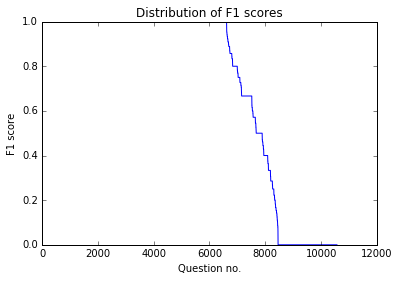

In [92]:
f1_distribution = sorted(predicted_f1s.values(), reverse=True)
plt.plot(np.arange(len(f1_distribution)), f1_distribution, 'b-')
plt.title("Distribution of F1 scores")
plt.ylabel("F1 score")
plt.xlabel("Question no.")

all_correct = len([ x for x in f1_distribution if x == 1.0 ])
zero = len([ x for x in f1_distribution if x == 0.0 ])
fraction = len(f1_distribution) - (all_correct + zero)

print "Examples with full F1: {0:.2f}%".format(all_correct * 100.0 / len(f1_distribution))
print "Examples with zero F1: {0:.2f}%".format(zero * 100.0 / len(f1_distribution))
print "Examples with partial F1: {0:.2f}%".format(fraction * 100.0 / len(f1_distribution))
plt.show()

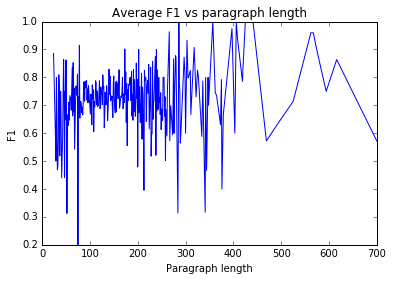

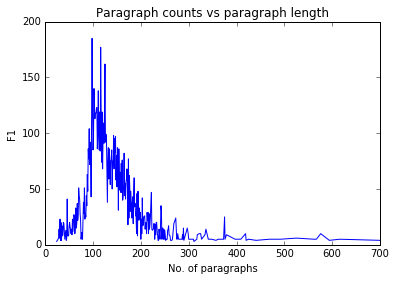

In [58]:
para_len_f1s = {}
for qid in predicted_f1s:
    para_id = qid_to_paraidx[qid]
    para_len = len(tokenized_paras[para_id])
    if not para_len in para_len_f1s:
        para_len_f1s[para_len] = [0, 0]
    para_len_f1s[para_len][0] += predicted_f1s[qid]
    para_len_f1s[para_len][1] += 1
    
xs = sorted(para_len_f1s.keys())
para_counts = {}
for para_len in para_len_f1s:
    para_counts[para_len] = para_len_f1s[para_len][1]
    para_len_f1s[para_len] = para_len_f1s[para_len][0]/float(para_len_f1s[para_len][1])
ys = [ para_len_f1s[x] for x in xs ]
plt.plot(xs, ys, 'b-')
plt.title("Average F1 vs paragraph length")
plt.ylabel("F1")
plt.xlabel("Paragraph length")
plt.show()

ys = [ para_counts[x] for x in xs ]
plt.plot(xs, ys, 'b-')
plt.title("Paragraph counts vs paragraph length")
plt.ylabel("F1")
plt.xlabel("No. of paragraphs")
plt.show()

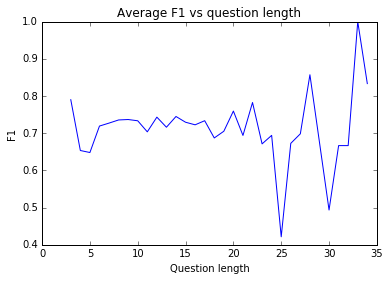

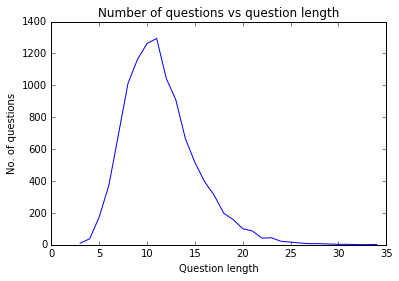

In [57]:
q_len_f1s = {}
for qid in predicted_f1s:
    q_len = len(word_tokenize(questions[qid]))
    if not q_len in q_len_f1s:
        q_len_f1s[q_len] = [0, 0]
    q_len_f1s[q_len][0] += predicted_f1s[qid]
    q_len_f1s[q_len][1] += 1
    
xs = sorted(q_len_f1s.keys())
q_counts = {}
for q_len in q_len_f1s:
    q_counts[q_len] = q_len_f1s[q_len][1]
    q_len_f1s[q_len] = q_len_f1s[q_len][0]/float(q_len_f1s[q_len][1])
ys = [ q_len_f1s[x] for x in xs ]
plt.plot(xs, ys, 'b-')
plt.title("Average F1 vs question length")
plt.ylabel("F1")
plt.xlabel("Question length")
plt.show()

ys = [ q_counts[x] for x in xs ]
plt.plot(xs, ys, 'b-')
plt.title("Number of questions vs question length")
plt.ylabel("No. of questions")
plt.xlabel("Question length")
plt.show()

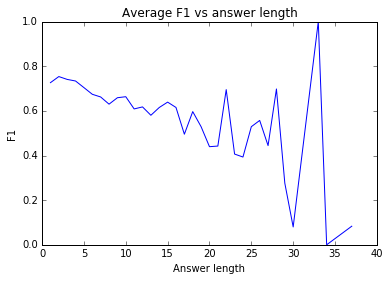

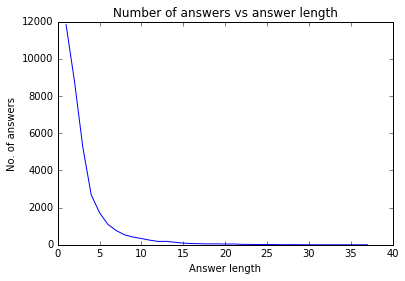

In [64]:
ans_len_f1s = {}
for _, ans_idxs, qid in dev_input:
    ans_len = ans_idxs[1]-ans_idxs[0]+1
    if not ans_len in ans_len_f1s:
        ans_len_f1s[ans_len] = [0, 0]
    ans_len_f1s[ans_len][0] += predicted_f1s[qid]
    ans_len_f1s[ans_len][1] += 1
    
xs = sorted(ans_len_f1s.keys())
ans_counts = {}
for ans_len in ans_len_f1s:
    ans_counts[ans_len] = ans_len_f1s[ans_len][1]
    ans_len_f1s[ans_len] = ans_len_f1s[ans_len][0]/float(ans_len_f1s[ans_len][1])
ys = [ ans_len_f1s[x] for x in xs ]
plt.plot(xs, ys, 'b-')
plt.title("Average F1 vs answer length")
plt.ylabel("F1")
plt.xlabel("Answer length")
plt.show()

ys = [ ans_counts[x] for x in xs ]
plt.plot(xs, ys, 'b-')
plt.title("Number of answers vs answer length")
plt.ylabel("No. of answers")
plt.xlabel("Answer length")
plt.show()

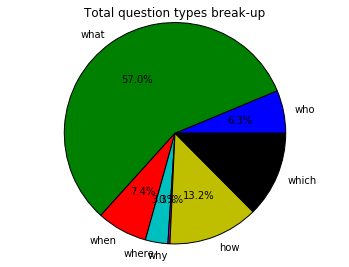

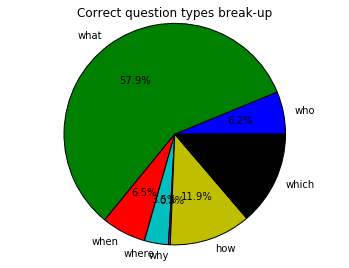

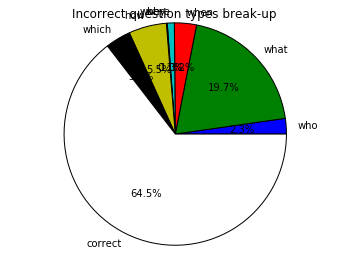

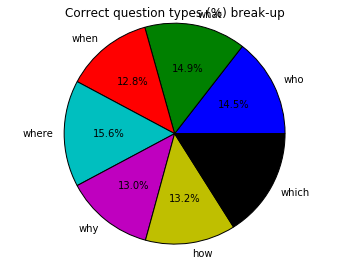

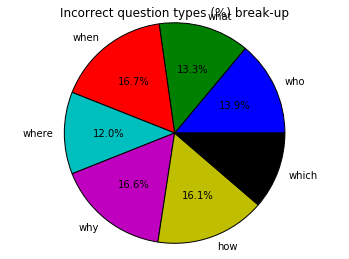

In [74]:
labels = ["who", "what", "when", "where", "why", "how", "which"]
totals = [0, 0, 0, 0, 0, 0, 0]
corrects = [0, 0, 0, 0, 0, 0, 0]
incorrects = [0, 0, 0, 0, 0, 0, 0]

for qid in predicted_f1s:
    for i, label in enumerate(labels):
        if label in questions[qid]:
            totals[i] += 1
            if predicted_f1s[qid] < 1.0:
                incorrects[i] += 1
            elif predicted_f1s[qid] == 1.0:
                corrects[i] += 1

fig1, ax1 = plt.subplots()
ax1.pie(totals, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Total question types break-up")
plt.show()

fig1, ax1 = plt.subplots()
ax1.pie(corrects, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Correct question types break-up")
plt.show()


fig1, ax1 = plt.subplots()
ax1.pie(incorrects + [sum(corrects)], labels=labels + ["correct"], autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Incorrect question types break-up")
plt.show()

totals, corrects, incorrects = \
    np.array(totals).astype(np.float32), np.array(corrects), np.array(incorrects)
fig1, ax1 = plt.subplots()
ax1.pie(corrects/totals, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Correct question types (%) break-up")
plt.show()

fig1, ax1 = plt.subplots()
ax1.pie(incorrects/totals, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Incorrect question types (%) break-up")
plt.show()

In [91]:
any_oov = 0
all_oov = 0
incorrect_all_oov = 0
incorrect_any_oov = 0
total = 0
all_oov_list = []
for _, ans_idxs, qid in dev_input:
    total += 1
    para = tokenized_paras[qid_to_paraidx[qid]]
    ans = [ dev_data.dictionary.get_word(para[idx]) \
              for idx in range(ans_idxs[0], ans_idxs[1]+1) ]
    is_oov = [ ans_word not in glove_vocab for ans_word in ans ]
    any_oov += any(is_oov)
    all_oov += all(is_oov)
    if any(is_oov):
        if predicted_f1s[qid] < 1.0:
            incorrect_any_oov += 1
    if all(is_oov):
        if predicted_f1s[qid] < 1.0:
            incorrect_all_oov += 1
        all_oov_list.append(" ".join(ans))
print "Answers with at-least one OOV word: {0:.2f}%".format(100 * any_oov/float(total))
print "Incorrect answers with at-least one OOV word: {0:.2f}%".format(100 * incorrect_any_oov/float(any_oov))
print "Answers with all OOV words: {0:.2f}%".format(100 * all_oov/float(total))
print "Incorrect answers with all OOV words: {0:.2f}%".format(100 * incorrect_all_oov/float(all_oov))
random.shuffle(all_oov_list)
print "All OOV list sample (%d):" % len(all_oov_list), all_oov_list[:10]

Answers with at-least one OOV word: 7.23%
Incorrect answers with at-least one OOV word: 44.25%
Answers with all OOV words: 2.85%
Incorrect answers with all OOV words: 42.97%
All OOV list sample (989): [u'\xa321,000', u'540,800', u'8\u201315', u'1754\u20131763', u'821,784', u'N\u2013S', u'Al-Muwaffaq', u'Pleurobrachia', u'\xa342,090', u'\xa326,719']
